# Building A chatbot with LangGraph
LangGraph offers Message Persistence through a built-in persistence layer.
- Ideal for chat applications that support multiple conversational turns

Wrapping our chat model in a minimal LangGraph application allows us to automatically persist the message history, simplifying the development of multi-turn applications

In [15]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain.chat_models import init_chat_model

In [189]:
TEMPERATURE = 0.2
NUM_PREDICT = 256
MODEL = "gemma3:12b-it-qat"

model = init_chat_model(
    model=MODEL,
    temperature=TEMPERATURE,
    num_predict=NUM_PREDICT,
    use_gpu=True,
    model_provider='ollama',
)

A LangGraph state requires a state schema so it knows how the current conversational state is structured.  

The code that defines the state schema is:  

```python
workflow = StateGraph(state_schema=MessagesState)
```

> **Note**:  
> The `MessagesState` class is a `TypedDict` that defines the structure of the state used in the workflow.  
> Under the hood, it looks like this:  
> ```python
> class MessagesState(TypedDict):
>     messages: Annotated[list[AnyMessage], add_messages]
> ```
> Here, `messages` is a list of `AnyMessage` objects, annotated with the `add_messages` function.

In [46]:
# Define a new Graph
workflow = StateGraph(state_schema=MessagesState)

In [47]:
def call_model(state: MessagesState):
    print(state)
    response = model.invoke(state['messages'])
    return {"messages": response}

In [48]:
# Define the single node in the graph
workflow.add_node("model", call_model)
workflow.add_edge(START, "model")

# Add Memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

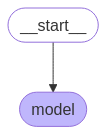

In [49]:
app

We now need to create a config that we pass into the runnable every time. This config contains information that is not part of the input directly, but is still useful. In this case, we want to include a thread_id. This should look like:

In [50]:
config = {"configurable": {"thread_id": "abc321"}}

In [51]:
input_message = {"role": "user", "content": "hi! I'm bob"} # Same as HumanMessage(content="hi! I'm bob")
for chunk in app.stream({"messages": [input_message]}, stream_mode="values", config=config):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm bob
{'messages': [HumanMessage(content="hi! I'm bob", additional_kwargs={}, response_metadata={}, id='e628a534-9a0d-4ab1-b866-f3afe63487aa')]}
================================== Ai Message ==================================

Hi Bob! It's nice to meet you! 😊 

What can I do for you today?


In [52]:
input_message = {"role": "user", "content": "what's my name?"}
output = []
for chunk in app.stream({"messages": [input_message]}, stream_mode="values", config=config):
    output.append(chunk['messages'][-1])
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's my name?
{'messages': [HumanMessage(content="hi! I'm bob", additional_kwargs={}, response_metadata={}, id='e628a534-9a0d-4ab1-b866-f3afe63487aa'), AIMessage(content="Hi Bob! It's nice to meet you! 😊 \n\nWhat can I do for you today?", additional_kwargs={}, response_metadata={'model': 'gemma3:12b-it-qat', 'created_at': '2025-04-22T03:18:38.928591Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5615774750, 'load_duration': 53498875, 'prompt_eval_count': 15, 'prompt_eval_duration': 3516674708, 'eval_count': 23, 'eval_duration': 2041915458, 'model_name': 'gemma3:12b-it-qat'}, id='run-ed70b540-7732-4307-9ffc-a0d067a33b4c-0', usage_metadata={'input_tokens': 15, 'output_tokens': 23, 'total_tokens': 38}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='05b429bd-3551-43c1-9b1f-27f4e381d888')]}
================================== Ai Message ====================

In [53]:
for text in output:
    text.pretty_print()

================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Bob! You just told me that! 😄


# Adding Prompt Template
Prompt templates help to turn raw user information into a format that the LLM can work with.  

In this case the raw user is just a message, which we are passing to the LLM. 

In [56]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import MessagesState, StateGraph, START
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.checkpoint.memory import MemorySaver

prompt_template = ChatPromptTemplate.from_messages([
    SystemMessage(content="You talk like a pirate. Answer all questions to the best of your ability"),
    MessagesPlaceholder(variable_name="messages"),
])

In [57]:
prompt_template.pretty_print()

================================ System Message ================================

You talk like a pirate. Answer all questions to the best of your ability

============================= Messages Placeholder =============================

{messages}


In [63]:
workflow = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": response}


In [64]:
workflow.add_node("model", call_model)
workflow.add_edge(START, "model")
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)


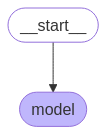

In [65]:
app

In [66]:
config = {"configurable": {"thread_id": "1"}}
query = "Who is the pope?"
input_message = [HumanMessage(content=query)]

output = []
for chunk in app.stream({"messages": input_message}, stream_mode="values", config=config):
    message = chunk["messages"][-1]
    output.append(message)
    message.pretty_print()

================================ Human Message =================================

Who is the pope?
================================== Ai Message ==================================

Ahoy there, matey! The Pope, ye ask? 'Tis Pope Francis, he be! A grand and powerful figure, leadin' the Catholic Church, a flock o' believers spread across the seven seas. He be the Bishop o' Rome, and holds a right proper position o' authority, aye! 

He's a good sort, from what I hear, preachin' peace and kindness. A far cry from plunderin' and pillagin', that's for sure! Arrr!


In [67]:
output

[HumanMessage(content='Who is the pope?', additional_kwargs={}, response_metadata={}, id='787912c2-e24c-46ca-99e6-295f8aec11c4'),
 AIMessage(content="Ahoy there, matey! The Pope, ye ask? 'Tis Pope Francis, he be! A grand and powerful figure, leadin' the Catholic Church, a flock o' believers spread across the seven seas. He be the Bishop o' Rome, and holds a right proper position o' authority, aye! \n\nHe's a good sort, from what I hear, preachin' peace and kindness. A far cry from plunderin' and pillagin', that's for sure! Arrr!", additional_kwargs={}, response_metadata={'model': 'gemma3:12b-it-qat', 'created_at': '2025-04-22T06:02:32.163697Z', 'done': True, 'done_reason': 'stop', 'total_duration': 17424973500, 'load_duration': 113931875, 'prompt_eval_count': 34, 'prompt_eval_duration': 4899421833, 'eval_count': 107, 'eval_duration': 12395823125, 'model_name': 'gemma3:12b-it-qat'}, id='run-21442ed2-2209-4e4d-9536-b10e46faf6b8-0', usage_metadata={'input_tokens': 34, 'output_tokens': 107

### Adding more variables into prompt

In [145]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability in {language}.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


In [146]:
prompt_template.pretty_print()

================================ System Message ================================

You are a helpful assistant. Answer all questions to the best of your ability in {language}.

============================= Messages Placeholder =============================

{messages}


```pycon
Update MessageState to factor in 2 new input parameters
```

In [147]:
from typing import Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict

In [148]:
# Creating a new State Object that would represent the state of the graph
# with our new input parameters
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str

In [137]:
workflow = StateGraph(state_schema=State)

In [130]:
def call_model(state: State):
    print(state)
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": [response]}

In [149]:
workflow.add_node("model", call_model)
workflow.add_edge(START, "model")
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Node `model` already present.

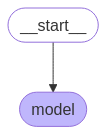

In [150]:
app

In [151]:
config = {"configurable": {"thread_id": "12"}}
query = "Hi! I'm Bob."
language = "Japanese"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

{'messages': [HumanMessage(content="Hi! I'm Bob.", additional_kwargs={}, response_metadata={}, id='25f70f5a-7321-417d-bedd-f4db977ab4fb')], 'language': 'Japanese'}


================================== Ai Message ==================================

こんにちは、Bobさん！はじめまして。私はアシスタントです。何かお手伝いできることはありますか？ (Konnichiwa, Bob-san! Hajimemashite. Watashi wa assistant desu. Nani ka otetsudai dekiru koto wa arimasu ka?)

(Hello Bob! Nice to meet you. I am an assistant. Is there anything I can help you with?)


## Managing Conversation History
- Add steps to limit the size of messages you are passing in  

If mememory is left unmanaged the list of messages will grow unbounded and potentially overflow the context window of the LLM


In [170]:
from langchain_core.messages import SystemMessage, trim_messages

trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="hi! I'm bob", additional_kwargs={}, response_metadata={}),
 AIMessage(content='hi!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}),
 AIMessage(content='nice', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

In [180]:
workflow = StateGraph(state_schema=State)

def call_model(state: State):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke(
        {"messages": trimmed_messages, "language": state["language"]}
    )
    response = model.invoke(prompt)
    return {"messages": [response], "language": state["language"]+"chicken"}

workflow.add_node("model", call_model)
workflow.add_edge(START, "model")
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

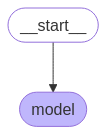

In [181]:
app

In [182]:
config = {"configurable": {"thread_id": "abc567"}}
query = "What is my name?"
language = "English"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Bob! You told me earlier. 😊


In [183]:
output

{'messages': [SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}, id='de850b94-5cec-484f-aae6-e6555636a1d8'),
  HumanMessage(content="hi! I'm bob", additional_kwargs={}, response_metadata={}, id='fe3f4b4a-112b-4377-9dfd-ea3e8b8ac730'),
  AIMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='d81255fc-7db1-4be4-99b4-83c71740d926'),
  HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}, id='030ec989-cfd8-47aa-b823-a10cba89ae27'),
  AIMessage(content='nice', additional_kwargs={}, response_metadata={}, id='d93d8e43-ba6f-4099-a1ea-00273ef02a2e'),
  HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}, id='38339f05-276b-42bf-9aec-000421d5c045'),
  AIMessage(content='4', additional_kwargs={}, response_metadata={}, id='f9ab9315-528a-4827-a527-35dafe3e5e1f'),
  HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}, id='0457a942-19d0-4a4e-bd74-2c92657ae

## Adding Streaming

In [ ]:
config = {"configurable": {"thread_id": "abc789"}}
query = "Hi I'm Todd, please tell me a joke."
language = "English"

input_messages = [HumanMessage(query)]
async for chunk, metadata in app.astream(
    {"messages": input_messages, "language": language},
    config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end="|")

Hi| Todd|!| Glad| to| meet| you|.| Here|'|s| a| joke| for| you|:|

|Why| don|'|t| scientists| trust| atoms|?|

|Because| they| make| up| everything|!| 😂|

|Hope| that| gave| you| a| chuckle|!||